In [1]:
from game_my import Game
from test import Test
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli
import copy
import random
%matplotlib inline

c:\Users\kingp\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.Softmax()
        )
        self.move_list = ((-1,0), (1,0), (0,-1), (0,1))

    def forward(self, x):
        y = self.layers_stack(x)
        return y

    def decode(self, v):
        return self.move_list[torch.argmax(v)]

In [3]:
def loss_fn(y, target):
  return F.l1_loss(y, target)

def count_w_score(field, w, coef=.5):
  c = {i:1 for i in field}
  score = 0
  for d in field:
    score += w[d]*c[d]
    c[d] = max(c[d], coef)
  return score
    

In [4]:
I = 12
w = [0]*I
for i in range(1,I):
  w[i] = 2**(i+1) + 2*w[i-1]
w[0] = 2
wd = {2**(i+1):w[i] for i in range(I)}
wd[0] = 0
print(wd)

{2: 2, 4: 4, 8: 16, 16: 48, 32: 128, 64: 320, 128: 768, 256: 1792, 512: 4096, 1024: 9216, 2048: 20480, 4096: 45056, 0: 0}


In [10]:
random.seed(2)
epoches = 500
batch_size = 20
batch_look_forward = 5
max_moves = 1000
lr = 3e-4
coef = 1

model = PolicyNet()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

gMoves = []
gScores = []
gLoss = []

best_field = []
best_score = 0

for e in tqdm(range(epoches)):
  moves = 0
  scores = 0
  mLoos = 0

  batch_fields = []
  batch_scores = []

  game = Game()
  game.gen_cell()
  while not game.end and moves <= max_moves:
    # GENERATE BATCHES
    tField = torch.FloatTensor(np.array(game.field).flatten())
    curMove = model(tField)
    with torch.no_grad():
      # SAVE STATISTICS
      field, score, end = game.step3(game.move_list[torch.argmax(curMove)])

      batch_fields.append(np.array(field).flatten())
      batch_scores.append(score if not end else -1/score)
      scores = max(scores, score)
      moves += 1

      if scores > best_score:
        best_score = scores
        best_field = [row for row in field]
        best_move = moves
    
    # TRAIN
    if not (moves % batch_size):
      pre_end = game.end
      pre_field = [row[:] for row in game.field]
      pre_score = game.score

      lf_fields = torch.tensor(batch_fields[:-batch_look_forward], dtype=torch.float)
      lf_scores = torch.tensor(batch_scores[batch_look_forward:], dtype=torch.float)
      # print(moves, game.end, end)
      batch_fields = []
      batch_scores = []
      optimizer.zero_grad()
      y = model(lf_fields)
      yy = []
      # with torch.no_grad():
      lf2_scores = []
      lscore = 0
      cfield = []
      for yi, yj in enumerate(y):
        game.save_game(lf_fields[yi], lf_scores[yi], pre_end)
        for i in range(batch_look_forward):
          cfield, lscore, end = game.step3(game.move_list[torch.argmax(yj)])
        yy.append(lscore)
        lf2_scores.append(count_w_score(np.array(cfield).flatten(), wd, coef))
        game.restore_game()
      yyy = torch.tensor(yy, dtype=torch.float, requires_grad=True)
      lf22_scores = torch.tensor(lf2_scores, dtype=torch.float, requires_grad=True)

      # print(lf_fields.shape, lf_scores.shape, yyy.shape)
      loss = loss_fn(yyy, lf22_scores)
      with torch.no_grad():
        mLoos = loss.mean().item()
      loss.backward()
      optimizer.step()

      game.end = pre_end
      game.field = pre_field
      game.score = pre_score

  gMoves.append(moves)
  gScores.append(scores)
  gLoss.append(mLoos)

  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\kingp\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 500/500 [00:12<00:00, 40.34it/s]


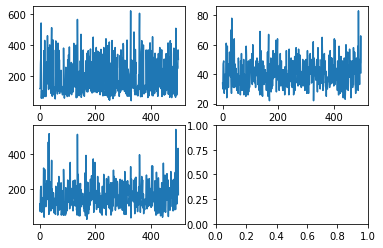

In [11]:
fig, axs = plt.subplots(2,2)
axs[0][0].plot(gLoss)
axs[0][1].plot(gMoves)
axs[1][0].plot(gScores)


In [8]:
a = pd.DataFrame(gScores)
a.describe()

,0
count,500.000000
mean,246.256000
std,119.654942
min,32.000000
25%,156.000000
50%,230.000000
75%,304.000000
max,760.000000


In [9]:
print(best_field, best_score, best_move)

[tensor(2, dtype=torch.int32), tensor(16, dtype=torch.int32), tensor(64, dtype=torch.int32), tensor(2, dtype=torch.int32), tensor(4, dtype=torch.int32), tensor(2, dtype=torch.int32), tensor(16, dtype=torch.int32), tensor(32, dtype=torch.int32), tensor(2, dtype=torch.int32), tensor(4, dtype=torch.int32), tensor(8, dtype=torch.int32), tensor(32, dtype=torch.int32), tensor(2, dtype=torch.int32), tensor(4, dtype=torch.int32), tensor(2, dtype=torch.int32), tensor(32, dtype=torch.int32)] 760 94


In [ ]:
epoches = 500
batch_size = 20
batch_look_forward = 10
max_moves = 1000
lr = 3e-6

model = PolicyNet()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

gMoves = []
gScores = []
gLoss = []

best_field = []
best_score = 0

for e in tqdm(range(epoches)):
  moves = 0
  scores = 0
  mLoos = 0

  batch_fields = []
  batch_scores = []

  game = Game()
  game.gen_cell()
  while not game.end and moves <= max_moves:
    # GENERATE BATCHES
    tField = torch.FloatTensor(np.array(game.field).flatten())
    curMove = model(tField)
    with torch.no_grad():
      # SAVE STATISTICS
      field, score, end = game.step2(torch.sort(curMove, descending=True)[1])

      batch_fields.append(np.array(field).flatten())
      batch_scores.append(score)
      scores = max(scores, score)
      moves += 1

      if scores > best_score:
        best_score = scores
        best_field = [row[:] for row in field]
        best_move = moves
    
    # TRAIN
    if not (moves % batch_size):
      pre_end = game.end
      pre_field = [row[:] for row in game.field]
      pre_score = game.score

      lf_fields = torch.tensor(batch_fields[:-batch_look_forward], dtype=torch.float)
      lf_scores = torch.tensor(batch_scores[batch_look_forward:], dtype=torch.float)
      # print(moves, game.end, end)
      batch_fields = []
      batch_scores = []
      optimizer.zero_grad()
      y = model(lf_fields)
      yy = []
      # with torch.no_grad():
      lscore = 0
      for yi, yj in enumerate(y):
        game.save_game(lf_fields[yi], lf_scores[yi], pre_end)
        for i in range(batch_look_forward):
          field, lscore, end = game.step2(torch.sort(yj, descending=True)[1])
        yy.append(lscore)
        game.restore_game()
      yyy = torch.tensor(yy, dtype=torch.float, requires_grad=True)

      # print(lf_fields.shape, lf_scores.shape, yyy.shape)
      loss = loss_fn(yyy, lf_scores)
      with torch.no_grad():
        mLoos = loss.mean().item()
      loss.backward()
      optimizer.step()

      game.end = pre_end
      game.field = pre_field
      game.score = pre_score

  gMoves.append(moves)
  gScores.append(scores)
  gLoss.append(mLoos)